In [ ]:
import ee
import geemap
!pip install xee
import xee
import xarray as xr
import pandas as pd
import numpy as np


In [2]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-lavibas23',
    opt_url='https://earthengine-highvolume.googleapis.com'
)

In [3]:
map = geemap.Map(basemap = 'SATELLITE')
map



Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [27]:
roi = map.draw_last_feature.geometry()

roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          80.785843,
                          6.895071
                        ],
                        [
                          80.785843,
                          7.159488
                        ],
                        [
                          81.081017,
                          7.159488
                        ],
                        [
                          81.081017,
                          6.895071
                        ],
                        [
                          80.785843,
                          6.895071
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [28]:
time_start = ee.Date('2010')
time_end = ee.Date('2020')
time_dif = time_end.difference(time_start, 'month').round()
time_list  =  ee.List.sequence(0, ee.Number(time_dif).subtract(1)).map(lambda i: time_start.advance(i, 'month'))
time_list

In [29]:
et = (
    ee.ImageCollection('projects/earthengine-legacy/assets/projects/usgs-ssebop/modis_et_v5_monthly')
    .filterDate(time_start, time_end)
    .select([0],['SSEBop'])
)

veg = (
    ee.ImageCollection("MODIS/061/MOD13A2")
    .filterDate(time_start, time_end)
    .select('NDVI', 'EVI')
)

temp = (
    ee.ImageCollection("MODIS/061/MOD11A2")
    .filterDate(time_start, time_end)
    .select('LST_Day_1km', 'LST_Night_1km')
)

etm = (
    ee.ImageCollection("MODIS/061/MOD16A2GF")
    .filterDate(time_start, time_end)
    .select(['ET'],['MODET'])
)

In [30]:
# convert to monthly format
def monthly(date, col):
  start_date = ee.Date(date)
  end_date = start_date.advance(1, 'month')
  img_mean = col.filterDate(start_date, end_date).mean()
  return img_mean.set('system:time_start', start_date.millis())


In [31]:
et_monthly = ee.ImageCollection(time_list.map(lambda x: monthly(x, et)))
veg_monthly = ee.ImageCollection(time_list.map(lambda x: monthly(x, veg)))
temp_monthly = ee.ImageCollection(time_list.map(lambda x: monthly(x, temp)))
etm_monthly = ee.ImageCollection(time_list.map(lambda x: monthly(x, etm)))

In [32]:
collection = veg_monthly.combine(temp_monthly).combine(etm_monthly).combine(et_monthly)

collection

In [33]:
ds = xr.open_dataset(
    collection,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.01,
    geometry = roi
)

ds


<xarray.Dataset> Size: 2MB
Dimensions:        (time: 120, lon: 30, lat: 26)
Coordinates:
  * time           (time) datetime64[ns] 960B 2010-01-01 ... 2018-04-01
  * lon            (lon) float64 240B 80.79 80.8 80.81 ... 81.06 81.07 81.08
  * lat            (lat) float64 208B 6.9 6.91 6.92 6.93 ... 7.12 7.13 7.14 7.15
Data variables:
    NDVI           (time, lon, lat) float32 374kB ...
    EVI            (time, lon, lat) float32 374kB ...
    LST_Day_1km    (time, lon, lat) float32 374kB ...
    LST_Night_1km  (time, lon, lat) float32 374kB ...
    MODET          (time, lon, lat) float32 374kB ...
    SSEBop         (time, lon, lat) float32 374kB ...
Attributes:
    crs:      EPSG:4326

In [34]:
df = ds.to_dataframe().dropna()

df

NDVI     EVI   LST_Day_1km  LST_Night_1km  \
time       lon       lat                                                     
2010-01-01 80.790843 6.900071  7282.0  4645.0  14771.500000       14216.75   
                     6.910071  7266.5  3988.0  14789.250000       14235.25   
                     6.920071  7252.5  4183.5  14765.500000       14247.00   
                     6.930071  6865.5  4298.5  14766.750000       14239.75   
                     6.940071  6991.5  4602.0  14841.750000       14217.75   
...                               ...     ...           ...            ...   
2018-04-01 81.080843 7.110071  8335.0  5602.5  15039.666992       14834.00   
                     7.120071  7910.0  5376.5  15097.000000       14851.00   
                     7.130071  6714.0  4098.0  15118.000000       14851.00   
                     7.140071  7771.5  4634.0  15096.000000       14857.00   
                     7.150071  7746.5  4601.5  15049.666992       14832.00   

                                    MODET  SSEBop  
time       lon       lat                           
2010-01-01 80.790843 6.900071  372.000000    16.0  
                     6.910071  332.250000    16.0  
                     6.920071  331.500000     8.0  
                     6.930071  318.250000    16.0  
                     6.940071  333.500000     0.0  
...                                   ...     ...  
2018-04-01 81.080843 7.110071  372.000000   123.0  
                     7.120071  430.333344   101.0  
                     7.130071  253.000000   115.0  
                     7.140071  325.333344   117.0  
                     7.150071  285.666656   125.0  

[88869 rows x 6 columns]

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
df.columns

Index(['NDVI', 'EVI', 'LST_Day_1km', 'LST_Night_1km', 'MODET', 'SSEBop'], dtype='object')

In [37]:
x = df[['NDVI', 'EVI', 'LST_Day_1km', 'LST_Night_1km', 'MODET']]
y = df['SSEBop']

In [38]:
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
model = RandomForestRegressor(
    n_estimators = 100,
    random_state = 42
)

In [41]:
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
y_pred = model.predict(x_test)

In [43]:
from sklearn.metrics import mean_absolute_error, r2_score

In [44]:
rmse = np.sqrt(mean_absolute_error(y_test, y_pred))
rmse

np.float64(4.415663451599321)

In [45]:
r2score = r2_score(y_test, y_pred)
r2score

0.5007706066915947

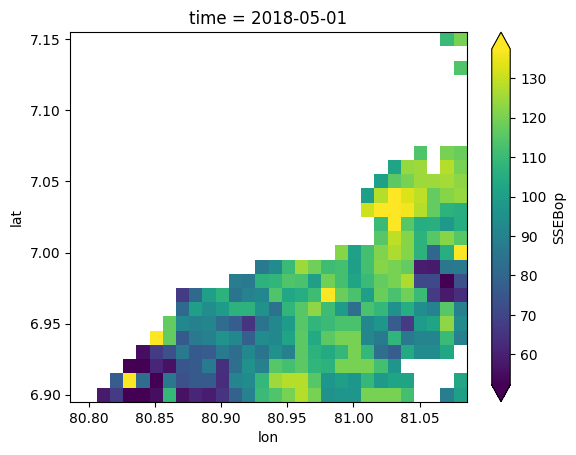

In [46]:
df['SSEBop_predicted'] = model.predict(df[['NDVI', 'EVI', 'LST_Day_1km', 'LST_Night_1km', 'MODET']])

xarr = df.to_xarray().sortby(['lat','lon','time'])

xarr.SSEBop.isel(time = 100).plot(
    x = 'lon',
    y = 'lat',
    robust = True
)


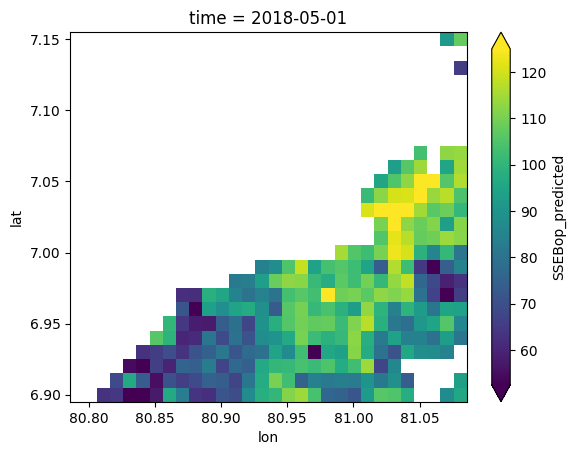

In [47]:
xarr.SSEBop_predicted.isel(time = 100).plot(
    x = 'lon',
    y = 'lat',
    robust = True
)


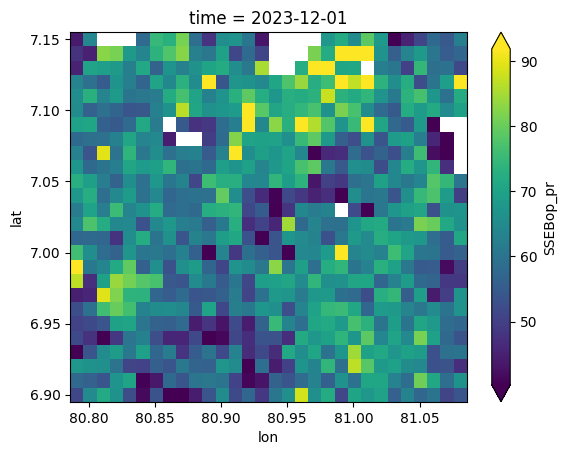

In [48]:
time_start = ee.Date('2023')
time_end = ee.Date('2025')
time_dif = time_end.difference(time_start, 'month').round()
time_list  =  ee.List.sequence(0, ee.Number(time_dif).subtract(1)).map(lambda i: time_start.advance(i, 'month'))
time_list

veg = (
    ee.ImageCollection("MODIS/061/MOD13A2")
    .filterDate(time_start, time_end)
    .select('NDVI', 'EVI')
)

temp = (
    ee.ImageCollection("MODIS/061/MOD11A2")
    .filterDate(time_start, time_end)
    .select('LST_Day_1km', 'LST_Night_1km')
)

etm = (
    ee.ImageCollection("MODIS/061/MOD16A2GF")
    .filterDate(time_start, time_end)
    .select(['ET'],['MODET'])
)

def monthly(date, col):
  start_date = ee.Date(date)
  end_date = start_date.advance(1, 'month')
  img_mean = col.filterDate(start_date, end_date).mean()
  return img_mean.set('system:time_start', start_date.millis())

veg_monthly = ee.ImageCollection(time_list.map(lambda x: monthly(x, veg)))
temp_monthly = ee.ImageCollection(time_list.map(lambda x: monthly(x, temp)))
etm_monthly = ee.ImageCollection(time_list.map(lambda x: monthly(x, etm)))

collection = veg_monthly.combine(temp_monthly).combine(etm_monthly)

ds = xr.open_dataset(
    collection,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.01,
    geometry = roi
)

df = ds.to_dataframe().dropna()

df['SSEBop_pr'] = model.predict(df[['NDVI', 'EVI', 'LST_Day_1km', 'LST_Night_1km', 'MODET']])

xarr = df.to_xarray().sortby(['lat','lon', 'time'])

xarr.SSEBop_pr.isel(time = 10).plot(
    x = 'lon',
    y ='lat',
    robust = True
)

In [49]:
!pip install netCDF4
import netCDF4

xarr.SSEBop_pr.to_netcdf('SSEBop_2023_2024.nc')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.6 MB/s eta 0:00:00
